# Regressive Normal Input Approach
This approach assumes that input for both training and testing is based of all the input data columns  from the "badmintondata.csv" and "badmintondata2.csv" files. Compared to the limited input approach, lesser features has to be generated as most of the features from the data are significance enough to be used. 

Random Forest Regressor is used to predict the data points of the trajectory, Decision Tree Classifier is used to determine number of observations an observation groups has.

## Importing Libraries and Dependencies

In [113]:
# %pip install pandas
# %pip install plotly
# %pip install scikit-learn
# %pip install numpy
# %pip install nbformat
# %pip install matplotlib

In [114]:
# preprocessing and feature generation
import pandas as pd
import numpy as np
import math

# feature significance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data mining and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import learning_curve

# visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot

## Stage: Preprocessing
Loading in Badminton Data
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION GROUP NUMBER"
- Data is also sequenced within each observation group with "OBSERVATION NUMBER"
- There are a total of 365 (index 0 - 364) observation groups here

Code is currently commented out as results has already been extracted

In [115]:
# # read csv data from badmintondata.csv
# serving_data = pd.read_csv('badmintondata.csv')

# # Initialize variables
# observation_group_num = 0
# observation_num = 0
# is_group = False

# # Process rows
# for index, row in serving_data.iterrows():
#     if row['HUMAN PLAYER POSITION (X) metres'] == 0:
#         if is_group:
#             is_group = False
#         serving_data.drop(index, inplace=True)
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4:
#         if is_group:
#             observation_num+=1
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         serving_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as int
# serving_data['OBSERVATION GROUP NUMBER'] = serving_data['OBSERVATION GROUP NUMBER'].astype(int)
# serving_data['HUMAN PLAYER POSITION (Z) metres'] = 1.6
# serving_data.to_csv('normal_data/normal_serving_data.csv')

Loading in the Badminton Rallying Data. 
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION GROUP NUMBER"
- Data is also sequenced within each observation group with "OBSERVATION NUMBER"
- There are a total of 1212 (index 365 - 1576) observation groups here

Code is currently commented out as results has already been extracted

In [116]:
# # read csv data from badmintondata.csv
# rallying_data = pd.read_csv('badmintondata2.csv')

# # Initialize variables
# observation_num = 0
# is_group = False

# # Process rows
# for index, row in rallying_data.iterrows():
#     if row['HUMAN PLAYER POSITION (X) metres'] == 0:
#         if is_group:
#             is_group = False
#         rallying_data.drop(index, inplace=True)
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4:
#         if is_group:
#             observation_num+=1
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         rallying_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         rallying_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as int
# rallying_data['OBSERVATION GROUP NUMBER'] = rallying_data['OBSERVATION GROUP NUMBER'].astype(int)
# rallying_data['HUMAN PLAYER POSITION (Z) metres'] = 2.6
# rallying_data.to_csv('normal_data/normal_rallying_data.csv')

Combining serving and rallying data

In [117]:
# # combining the serving and rally dataframes
# normal_badminton_data = pd.concat([serving_data, rallying_data], ignore_index=True)
# # just renaming some of the data columns to avoid unnecessary errors
# normal_badminton_data = normal_badminton_data.rename(columns={'SHUTTLECOCK POSITIION IN AIR(X ) metres': 'SHUTTLECOCK POSITIION IN AIR(X) metres'})
# normal_badminton_data = normal_badminton_data.rename(columns={'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)': 'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'})

# normal_badminton_data.to_csv('normal_data/normal_badminton_data.csv')

label data if they are are out of bounds within the observations using data column "OUT OF BOUNDS". This includes
- Data that exceeds the X axis (hit too far on both sides) X < 0 OR X > 13.4
- Data that exceeds the Y axis (hit out of court on left or right side) Y < 0 OR Y > 5.18
- Data that is out of bounds labelled as 1, no 0

OPTIONAL, if needed

In [118]:
# # labelling data if its out of bounds
# unique_observation_number = badminton_data['OBSERVATION GROUP NUMBER'].unique()
# for obs_grp_number in unique_observation_number:
#     last_row = badminton_data[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number].tail(1)
#     # Check the conditions for 'Shuttlecock Position in Air X' and 'Shuttlecock Position in Air Y'
#     if (last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] > 13.4 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] > 5.18):
        
#         # Set 'OUT OF BOUNDS' column to 1 for the corresponding observation number
#         badminton_data.loc[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS'] = 1
#     else:
#         badminton_data.loc[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS']

## Feature Significance
Selecting features to test significance using PCA and standardizing them. 

In [119]:
# load combined data
normal_badminton_data = pd.read_csv('normal_data/normal_badminton_data.csv')
normal_badminton_data.drop(columns=['Unnamed: 0'])
# determine x features
X_normal_features = normal_badminton_data.drop(columns=['OBSERVATION GROUP NUMBER',
                                            'SHUTTLECOCK POSITIION IN AIR(X) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Z) metres'])
# Standardize the data
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_normal_features)

Feature INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE): Significance = 0.1575130972671529
Feature OBSERVATION NUMBER: Significance = 0.14451771008579112
Feature HUMAN PLAYER POSITION (Z) metres: Significance = 0.14346591469930792
Feature HUMAN PLAYER POSITION (Y) metres: Significance = 0.1289000556047668
Feature Unnamed: 0: Significance = 0.12780743413729465
Feature INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE): Significance = 0.1209264291415387
Feature INITITAL VELOCITY OF SHUTTELCOCK(m/s): Significance = 0.11598742657766425
Feature HUMAN PLAYER POSITION (X) metres: Significance = 0.06088193248648372


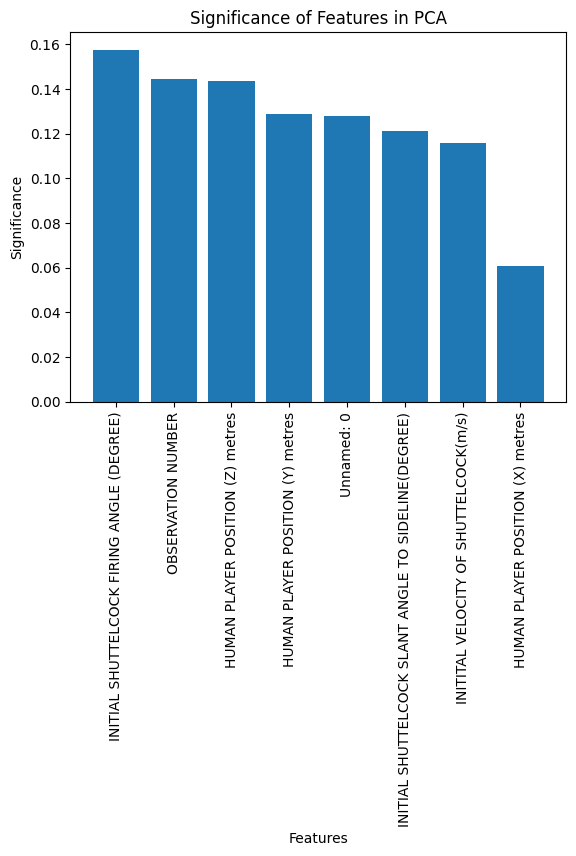

In [120]:
# instantiate PCA object, fit model
pca = PCA()
pca.fit(X_features_norm)

# loadings refer to the coefficients or weights that determine the contribution of each feature to the principal components
# Get the absolute loadings for each feature in each principal component
absolute_loadings = np.abs(pca.components_)
# Calculate the total sum of absolute loadings for each feature across all principal components
total_loadings = np.sum(absolute_loadings, axis=0)

# Calculate the relative contribution of each feature to the total loadings
relative_contribution = total_loadings / np.sum(total_loadings)

# Sort the features based on their relative contribution
sorted_features = np.argsort(relative_contribution)[::-1]
feature_names = X_normal_features.columns
# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_names[feature_idx]}: Significance = {relative_contribution[feature_idx]}")

# Plot the significance of each feature
plt.bar(range(len(sorted_features)), relative_contribution[sorted_features])
plt.xlabel('Features')
plt.ylabel('Significance')
plt.title('Significance of Features in PCA')
plt.xticks(range(len(sorted_features)), feature_names[sorted_features], rotation=90)
# plt.xticks(range(len(sorted_features)), sorted_features)
plt.show()

## Stage: Data Mining
### Preparing data for Decision Tree Classifier
To determine observation steps needed for a trajectory, only these X features are needed. No normalization is needed
- 'HUMAN PLAYER POSITION (X) metres'
- 'HUMAN PLAYER POSITION (Y) metres'
- 'HUMAN PLAYER POSITION (Z) metres'
- 'INITITAL VELOCITY OF SHUTTELCOCK(m/s)'
- 'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'
- 'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'

In [121]:
# loading data
data = pd.read_csv('normal_data/normal_badminton_data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Drop duplicates based on 'Observation Group Number', keeping only the last record
data_DT = data.copy()
data_DT = data_DT.drop_duplicates(subset='OBSERVATION GROUP NUMBER', keep='last')

# Define X and Y Features for Decision Tree
X_features_DT = data_DT[['HUMAN PLAYER POSITION (X) metres', 
                        'HUMAN PLAYER POSITION (Y) metres', 
                        'HUMAN PLAYER POSITION (Z) metres', 
                        'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                        'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                        'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

Y_feature_DT = data_DT['OBSERVATION NUMBER']

# Split the data into train/test, X/Y for Decision Tree Classifier
X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_features_DT, Y_feature_DT, test_size=0.2, random_state=42)

### Finding Optimal Decision Tree Model
To predict total observation time based on the independent feature supplied. Predicts a set of observation take

In [122]:
from sklearn.tree import DecisionTreeClassifier
maxdepths = [2,3,4,5,6,7,8,9,10,15]  # 10 different depths

# containers to store train/test accuracy rates
trainAcc_DT = np.zeros(len(maxdepths))
testAcc_DT = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    # training decision tree with depth lengths
    temp_model_DT = DecisionTreeClassifier(max_depth=depth)
    temp_model_DT = temp_model_DT.fit(X_train_DT, Y_train_DT)
    # generate predictions using the model trained, for the training data (X) and test data (X)
    Y_predTrain = temp_model_DT.predict(X_train_DT)
    Y_predTest = temp_model_DT.predict(X_test_DT)
    # compare the predicted values and compare against original values for accuracy
    trainAcc_DT[index] = accuracy_score(Y_train_DT, Y_predTrain)
    testAcc_DT[index] = accuracy_score(Y_test_DT, Y_predTest)
    index += 1

Text(0, 0.5, 'Accuracy')

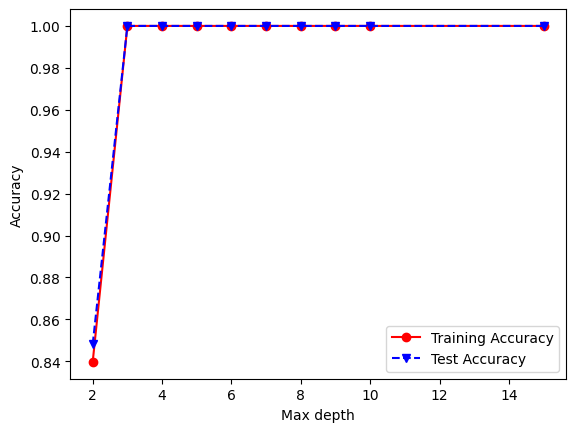

In [123]:
plt.plot(maxdepths,trainAcc_DT,'ro-',maxdepths,testAcc_DT,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

### Train Decision Tree Model "Model_DecisionTree"
Using the optimal elbow depth found in the previous segment which is 3

In [124]:
model_decisionTree = DecisionTreeClassifier(max_depth=3)
model_decisionTree = model_decisionTree.fit(X_train_DT, Y_train_DT)

Y_predTrain = model_decisionTree.predict(X_train_DT)
Y_predTest = model_decisionTree.predict(X_test_DT)

trainAcc_DT = accuracy_score(Y_train_DT, Y_predTrain)
testAcc_DT = accuracy_score(Y_test_DT, Y_predTest)
print("Training Accuracy: ", trainAcc_DT)
print("Testing Accuracy: ", testAcc_DT)

Training Accuracy:  1.0
Testing Accuracy:  1.0


### Preparing data for Regression Models

In [125]:
# Define X and Y features
X_features_Regression = data[['HUMAN PLAYER POSITION (X) metres', 
                        'HUMAN PLAYER POSITION (Y) metres', 
                        'HUMAN PLAYER POSITION (Z) metres',
                        'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                        'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                        'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                        'OBSERVATION NUMBER']]

Y_features_Regression = data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
                        'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                        'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

# splitting data into X, Y train test, 80/20
X_train_Regression, X_test_Regression, Y_train_Regression, Y_test_Regression = train_test_split(X_features_Regression, Y_features_Regression, test_size=0.2, random_state=42)

### Random Forest Regressor
Random Forest is an ensemble learning algorithm that combines multiple decision trees to make predictions. It can handle both numerical and categorical data and is capable of capturing complex relationships in the data. It does not require feature standardization as they are not sensitive to the scale of the features. Random Forest algorithms work by creating decision trees based on random subsets of features, and each decision tree independently makes decisions based on these features.
#### Dependencies for Random Forest Regressor

In [126]:
from sklearn.ensemble import RandomForestRegressor  # for regression tasks

### Optimizing Random Forest Regressor
Building multiple models with different depths to find best model with lowest mean squared error. Best depth should be 15

In [127]:
# # Define a list of depths to test
# depths = [5, 10, 15, 20, 25, 30]
# mse_scores_depth_RF = []

# # Iterate over different depths and calculate MSE
# for depth in depths:
#     temp_model_RF = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42)
#     temp_model_RF.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_RF.predict(X_test_Regression)
#     temp_mse_depth_RF = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_scores_depth_RF.append(temp_mse_depth_RF)
# print(mse_scores_depth_RF)

In [128]:
# # Plotting the MSE scores
# plt.plot(depths, mse_scores_depth_RF, marker='o')
# plt.xlabel('Depth')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. Depth for Random Forest Regressor')
# plt.show()

Building multiple models with different number of decision trees "n_estimators" to find best "n_estimator". Best number of decision trees should be 200

In [129]:
# # Define a list of n_estimators to test
# n_estimators_values = [50, 100, 150, 200, 250, 300]
# mse_score_nestimator_RF = []

# # Iterate over different n_estimators and calculate MSE
# for n_estimators in n_estimators_values:
#     temp_model_RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, random_state=42)
#     temp_model_RF.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_RF.predict(X_test_Regression)
#     temp_mse_nestimator_RF = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_score_nestimator_RF.append(temp_mse_nestimator_RF)
# print(mse_score_nestimator_RF)

In [130]:
# # Plotting the MSE scores
# plt.plot(n_estimators_values, mse_score_nestimator_RF, marker='o')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. n_estimators for Random Forest Regressor')
# plt.show()

### Training with Best Random Forest Regressor
This model will allow us predict an X, Y, Z coordinate in relation to the independent features supplied

In [131]:
model_randomForest = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)  # for regression

model_randomForest.fit(X_train_Regression, Y_train_Regression)
y_pred_RF = model_randomForest.predict(X_test_Regression)

### Training Evaluation of Random Forest Regressor
Mean squared error and root mean squared errors are error margin metrics for regression models. Refer to root mean squared error for a closer error margin to original metric

In [132]:
mse_RF = mean_squared_error(Y_test_Regression, y_pred_RF)
print("Mean Squared Error:", mse_RF)
rmse_RF = math.sqrt(mse_RF)
print("Root Mean Squared Error:", rmse_RF)

Mean Squared Error: 0.0006107810321599828
Root Mean Squared Error: 0.024713984546405762


Check for generalization of data and if data is able to capture underlying pattern properly. This is done with a learning curve, with a negative mean squared metric. If the training and validation lines converge at a low error rate, that means that the model is well generalized and captures patterns properly

In [133]:
# # Calculate the learning curves
# train_sizes, train_scores, val_scores = learning_curve(model_randomForest, X_train_Regression, Y_train_Regression, cv=5, scoring='neg_mean_squared_error')

# # Calculate the mean and standard deviation of train and validation scores
# train_mean = -np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = -np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

In [134]:
# # Plot the learning curves
# plt.figure(figsize=(10, 7))
# plt.plot(train_sizes, train_mean, label='Training score', color='blue')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
# plt.plot(train_sizes, val_mean, label='Validation score', color='red')
# plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
# plt.xlabel('Training Set Size')
# plt.ylabel('Negative Mean Squared Error')
# plt.title('Learning Curve for Random Forest Regressor')
# plt.legend(loc='best')
# plt.show()

### Model Visualization of Random Forest Regressor

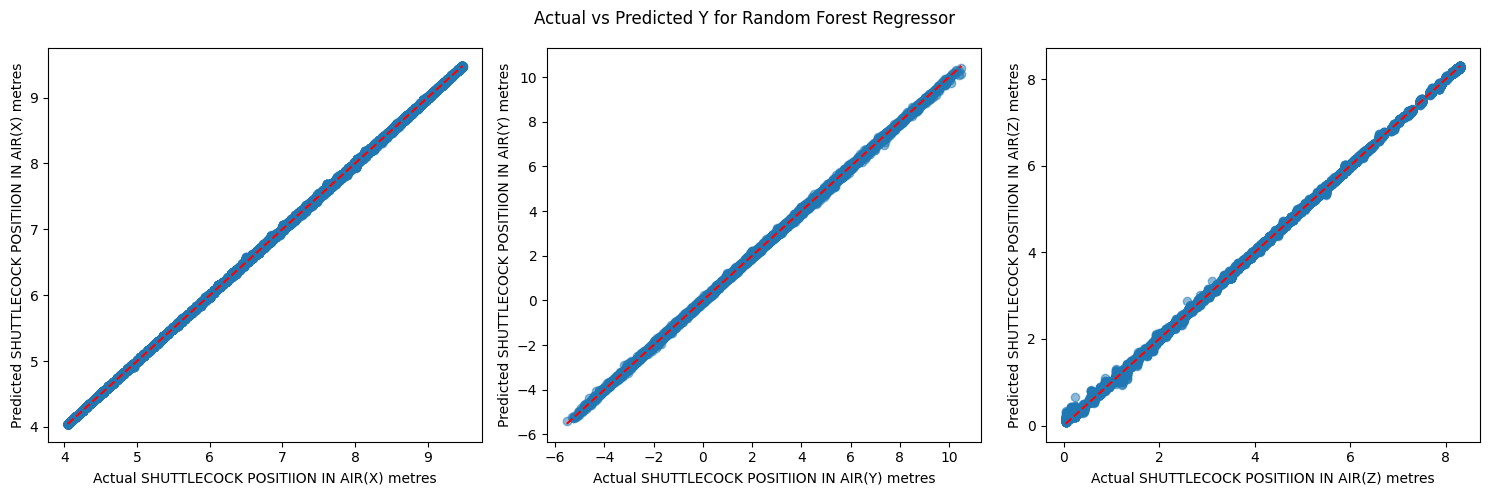

In [135]:
# Plotting the scatterplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each target variable
for i, target in enumerate(Y_features_Regression.columns):
    ax[i].scatter(Y_test_Regression[target], y_pred_RF[:, i], alpha=0.5)
    ax[i].plot([Y_test_Regression[target].min(), Y_test_Regression[target].max()], [Y_test_Regression[target].min(), Y_test_Regression[target].max()], 'r--')
    ax[i].set_xlabel('Actual ' + target)
    ax[i].set_ylabel('Predicted ' + target)

plt.suptitle('Actual vs Predicted Y for Random Forest Regressor')
plt.tight_layout()
plt.show()

Interactive Display of Entire Trained Regressive Model

In [136]:
import plotly.graph_objects as go
from plotly.offline import plot

# Create traces for actual and predicted values
actual_trace = go.Scatter3d(
    x=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(X) metres'],
    y=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
    z=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
    name='Actual',
    mode='markers',
    marker=dict(
        color='blue',
        size=3,
        symbol='circle'
    )
)

predicted_trace = go.Scatter3d(
    x=y_pred_RF[:, 0],
    y=y_pred_RF[:, 1],
    z=y_pred_RF[:, 2],
    name='Predicted',
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle'
    )
)

# Create layout
layout = go.Layout(
    title='Actual vs Predicted Shuttlecock Positions for Random Forest Regressor',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Save the plot as an HTML file
plot(fig, filename='interactive_models/random_forest_normal_model.html')

'interactive_models/random_forest_normal_model.html'

### Extra Trees Regressor
Extra Trees aka. (Extremely Randomized Trees) Regressor is a variant of Random Forest Tree which also uses an ensemble of decision trees to make predictions. However unlike random forests, Extra Trees introduces extra randomness by randomly selecting features at each node split. This randomness helps to create more diverse and less correlated trees. The final prediction is obtained by averaging the predictions of all the trees.
#### Dependencies for Extra Trees Regressor

In [137]:
from sklearn.ensemble import ExtraTreesRegressor

### Optimization of Extra Tree Regressor 
Building multiple models with different depths to find best model with lowest mean squared error. Best depth should be 15

In [138]:
# # Define a list of depths to test
# depths = [5, 10, 15, 20, 25, 30]
# mse_scores_depth_ET = []

# # Iterate over different depths and calculate MSE
# for depth in depths:
#     temp_model_ET = ExtraTreesRegressor(n_estimators=100, max_depth=depth, random_state=42)
#     temp_model_ET.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_ET = temp_model_ET.predict(X_test_Regression)
#     temp_mse_depth_ET = mean_squared_error(Y_test_Regression, temp_y_pred_ET)
#     mse_scores_depth_ET.append(temp_mse_depth_ET)

In [139]:
# # Plotting the MSE scores
# plt.plot(depths, mse_scores_depth_ET, marker='o')
# plt.xlabel('Depth')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. Depth for Extra Trees Regressor')
# plt.show()

Building multiple models with different number of decision trees "n_estimators" to find best "n_estimator". Best number of decision trees should be 200

In [140]:
# # Define a list of n_estimators to test
# n_estimators_values = [50, 100, 150, 200, 250, 300]
# mse_scores_nestimator_ET = []

# # Iterate over different n_estimators and calculate MSE
# for n_estimators in n_estimators_values:
#     temp_model_ET = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, random_state=42)
#     temp_model_ET.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_ET.predict(X_test_Regression)
#     temp_mse_nestimator_ET = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_scores_nestimator_ET.append(temp_mse_nestimator_ET)
# print(mse_scores_nestimator_ET)

In [141]:
# # Plotting the MSE scores
# plt.plot(n_estimators_values, mse_scores_nestimator_ET, marker='o')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. n_estimators for Extra Trees Regressor')
# plt.show()

### Training with Best Extra Trees Regressor
This model will allow us predict an X, Y, Z coordinate in relation to the independent features supplied

In [142]:
# Define the Extra Trees Regressor
model_ExtraTrees = ExtraTreesRegressor()
model_ExtraTrees.fit(X_train_Regression, Y_train_Regression)
y_pred_ET = model_ExtraTrees.predict(X_test_Regression)

### Training Evaluation of Extra Trees Regressor
Mean squared error and root mean squared errors are error margin metrics for regression models. Refer to root mean squared error for a closer error margin to original metric

In [143]:
mse_ET = mean_squared_error(Y_test_Regression, y_pred_ET)
print("Mean Squared Error:", mse_ET)
rmse_ET = math.sqrt(mse_ET)
print("Root Squared Error:", rmse_ET)

Mean Squared Error: 0.00011387440756061318
Root Squared Error: 0.010671195226431441


Check for generalization of data and if data is able to capture underlying pattern properly. This is done with a learning curve, with a negative mean squared metric. If the training and validation lines converge at a low error rate, that means that the model is well generalized and captures patterns properly

In [144]:
# # Calculate the learning curves
# train_sizes, train_scores, val_scores = learning_curve(model_ExtraTrees, X_train_Regression, Y_train_Regression, cv=5, scoring='neg_mean_squared_error')

# # Calculate the mean and standard deviation of train and validation scores
# train_mean = -np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = -np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

In [145]:
# # Plot the learning curves
# plt.figure(figsize=(10, 7))
# plt.plot(train_sizes, train_mean, label='Training score', color='blue')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
# plt.plot(train_sizes, val_mean, label='Validation score', color='red')
# plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
# plt.xlabel('Training Set Size')
# plt.ylabel('Negative Mean Squared Error')
# plt.title('Learning Curve for Extra Trees')
# plt.legend(loc='best')
# plt.show()

### Model Visualization of Extra Trees Regressor

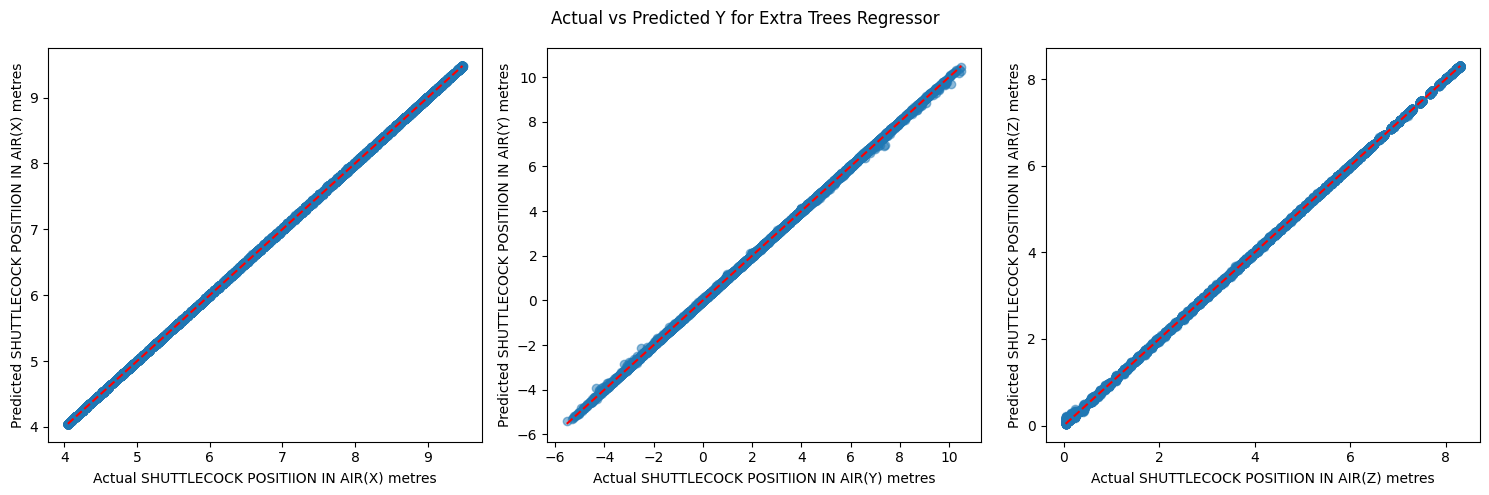

In [146]:
# Plotting the scatterplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each target variable
for i, target in enumerate(Y_features_Regression.columns):
    ax[i].scatter(Y_test_Regression[target], y_pred_ET[:, i], alpha=0.5)
    ax[i].plot([Y_test_Regression[target].min(), Y_test_Regression[target].max()], [Y_test_Regression[target].min(), Y_test_Regression[target].max()], 'r--')
    ax[i].set_xlabel('Actual ' + target)
    ax[i].set_ylabel('Predicted ' + target)

plt.suptitle('Actual vs Predicted Y for Extra Trees Regressor')
plt.tight_layout()
plt.show()

In [147]:
# Create traces for actual and predicted values
actual_trace = go.Scatter3d(
    x=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(X) metres'],
    y=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
    z=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
    name='Actual',
    mode='markers',
    marker=dict(
        color='blue',
        size=3,
        symbol='circle'
    )
)

predicted_trace = go.Scatter3d(
    x=y_pred_ET[:, 0],
    y=y_pred_ET[:, 1],
    z=y_pred_ET[:, 2],
    name='Predicted',
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle'
    )
)

# Create layout
layout = go.Layout(
    title='Actual vs Predicted Shuttlecock Positions for Extra Trees Regressor',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Save the plot as an HTML file
plot(fig, filename='interactive_models/extra_trees_normal_model.html')

'interactive_models/extra_trees_normal_model.html'

## Stage: Actual Testing with First Coordinate
To actually test if all the models work, the first point of an observation group will be used for testing. Test will be randomized and based on observation group. Assuming that we will know the sequence order of the observation since they are ordered, OBSERVATION NUMBER will be used to identify the first observation

In [148]:
import random
# copied to avoid alterations to cleaned data
test_data = data.copy()

# choose a random record from the observation groups to test
unique_observation_grps = test_data['OBSERVATION GROUP NUMBER'].nunique()
selected_test_num = random.randint(1, unique_observation_grps)
print("Selected Observation Group Number is :", selected_test_num)

# alternatively can hardcode to replicate results
# selected_test_num = ?

# retrieve all the rows from the data related to randomly selected row
y_actual_records = test_data[test_data['OBSERVATION GROUP NUMBER'] == selected_test_num]

# get the first row of selected observation for input
y_first_record = y_actual_records.head(1)

# show the test data
y_first_record

Selected Observation Group Number is : 347


,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,INITITAL VELOCITY OF SHUTTELCOCK(m/s),INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE),INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE),SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,OBSERVATION GROUP NUMBER,HUMAN PLAYER POSITION (Z) metres
38456,4,3,70,70,24,4.238179,3.106044,2.236338,1.0,347,1.6


Predict number of observations within a Trajectory for test record

In [149]:
# select the input features we want to feed into the decision tree model to prediction observation
X_actual_test_DT = y_first_record[['HUMAN PLAYER POSITION (X) metres', 
                                    'HUMAN PLAYER POSITION (Y) metres',
                                    'HUMAN PLAYER POSITION (Z) metres', 
                                    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                                    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                                    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

predicted_observation = int(model_decisionTree.predict(X_actual_test_DT))
print("Predicted observation is :", predicted_observation)
print("Actual number of observations is :", len(y_actual_records))

Predicted observation is : 39
Actual number of observations is : 39


Prepare input features to be fed into Regressor Models

In [150]:
# container to store prepared input features we want to feed into the regression model to predict entire trajectory x, y, z coordinates
Y_actual_test_Regression = []
# select x features and change the observation number accordingly and add into container
for obs_num in range(1, predicted_observation+1):
    temp = (y_first_record[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres',
                            'HUMAN PLAYER POSITION (Z) metres',
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]).values.tolist()
    temp_obs_row = temp[:5][0]
    temp_obs_row.append(obs_num)
    Y_actual_test_Regression.append(temp_obs_row)

Y_actual_test_Regression

[[4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 1],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 2],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 3],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 4],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 5],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 6],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 7],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 8],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 9],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 10],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 11],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 12],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 13],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 14],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 15],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 16],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 17],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 18],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 19],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 20],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 21],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 22],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 23],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 24],
 [4.0, 3.0, 1.6, 70.0, 70.0, 24.0, 25],
 [4.0, 3.

In [151]:
# Turn it into dataframe
column_names = [
    'HUMAN PLAYER POSITION (X) metres',
    'HUMAN PLAYER POSITION (Y) metres',
    'HUMAN PLAYER POSITION (Z) metres',
    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)',
    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)',
    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
    'OBSERVATION NUMBER'
]

X_actual_test_Regression_DF = pd.DataFrame(Y_actual_test_Regression, columns = column_names)

Predict the Trajectory using Trained Models, outputs an array of predicted shuttlecock trajectory coordinates

In [152]:
# prediction using random forest regression
predicted_trajectory_points_RT = model_randomForest.predict(X_actual_test_Regression_DF)
# prediction using extra trees regression
predicted_trajectory_points_ET = model_ExtraTrees.predict(X_actual_test_Regression_DF)

### Overall Evaluation for all Regression Models

In [153]:
# Do an error evaluation
y_actual_coords = y_actual_records[['SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres', 'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

mse_actual_RT = mean_squared_error(y_actual_coords, predicted_trajectory_points_RT)
rmse_actual_RT = math.sqrt(mse_actual_RT)
print("Mean Square Error of the Random Forest Tree Regressor is :", mse_actual_RT)
print("Root Mean Square Error of the Random Forest Tree Regressor is :", rmse_actual_RT)

mse_actual_ET = mean_squared_error(y_actual_coords, predicted_trajectory_points_ET)
rmse_actual_ET = math.sqrt(mse_actual_ET)
print("Mean Square Error of the Extra Trees Regressor is :", mse_actual_ET)
print("Root Mean Square Error of the Extra Trees Regressor is :", rmse_actual_ET)

Mean Square Error of the Random Forest Tree Regressor is : 0.0026732151453503546
Root Mean Square Error of the Random Forest Tree Regressor is : 0.05170314444354767
Mean Square Error of the Extra Trees Regressor is : 8.11328970574531e-05
Root Mean Square Error of the Extra Trees Regressor is : 0.009007380143940473


Static Visualization of Shuttlecock Trajectory in a Court

In [154]:
#Court Constants
_HEIGHT_SKYBOX_M_ = 10
_HEIGHT_NET_M_ = 1.55
_HEIGHT_ROBOTBADMINTON_CENTER_M_ = 1.1

_LENGTH_COURT_X_M_ = 13.4
_LENGTH_COURT_Y_M_ = 5.18
_LENGTH_CENTERLINE_M_ = 4.68

_COURT_BOUNDARY_TOP_ = [
 (0,0),
 (0, _LENGTH_COURT_Y_M_)
]
_COURT_BOUNDARY_BOTTOM_ = [
 (_LENGTH_COURT_X_M_, 0),
 (_LENGTH_COURT_X_M_, _LENGTH_COURT_Y_M_)
]
_COURT_BOUNDARY_LEFT_ = [
 (0,0),
 (_LENGTH_COURT_X_M_, 0)
]
_COURT_BOUNDARY_RIGHT_ = [
 (0, _LENGTH_COURT_Y_M_),
 (_LENGTH_COURT_X_M_, _LENGTH_COURT_Y_M_)
]

_COURT_CENTRELINE01_ = [
 (0, (_LENGTH_COURT_Y_M_/2)),
 (_LENGTH_CENTERLINE_M_, (_LENGTH_COURT_Y_M_/2))
]
_COURT_CENTRELINE02_ = [
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_, (_LENGTH_COURT_Y_M_/2)),
    (_LENGTH_COURT_X_M_, (_LENGTH_COURT_Y_M_/2))
]
_COURT_SHORTSERVICELINE01_ = [
    (_LENGTH_CENTERLINE_M_ + 0.04, 0),
    (_LENGTH_CENTERLINE_M_ + 0.04, _LENGTH_COURT_Y_M_)
]
_COURT_SHORTSERVICELINE02_ = [
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_ - 0.04, 0),
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_ - 0.04, _LENGTH_COURT_Y_M_)
]

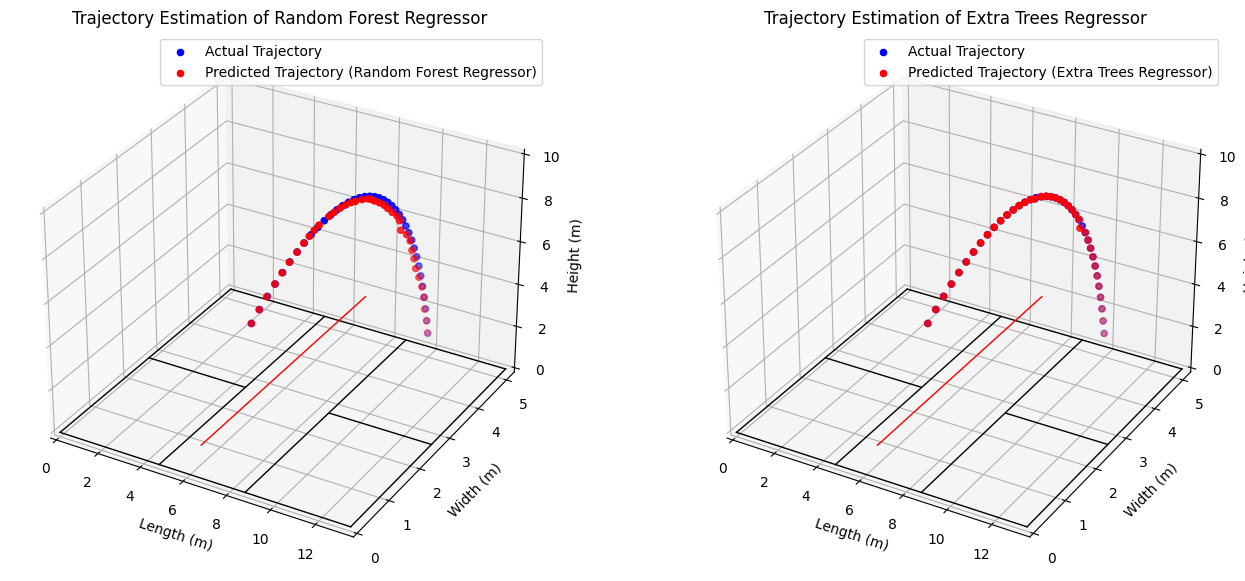

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), subplot_kw={'projection': '3d'})

# Set titles for subplots
axes[0].set_title("Trajectory Estimation of Random Forest Regressor")
axes[1].set_title("Trajectory Estimation of Extra Trees Regressor")

# Define court dimensions
court_length_x = 13.4
court_length_y = 5.18
court_height_skybox = 10
court_height_net = 1.55
court_height_robotbadminton_center = 1.1
court_length_centerline = 4.68

# Loop over subplots
for ax_index, ax in enumerate(axes):
    # Plot court boundaries
    ax.plot([0, court_length_x], [0, 0], [0, 0], color='black', linewidth=1)  # Bottom boundary
    ax.plot([0, court_length_x], [court_length_y, court_length_y], [0, 0], color='black', linewidth=1)  # Top boundary
    ax.plot([0, 0], [0, court_length_y], [0, 0], color='black', linewidth=1)  # Left boundary
    ax.plot([court_length_x, court_length_x], [0, court_length_y], [0, 0], color='black', linewidth=1)  # Right boundary

    # Plot center line
    ax.plot([0, court_length_centerline], [court_length_y / 2, court_length_y / 2], [0, 0], color='black', linewidth=1)
    ax.plot([court_length_x - court_length_centerline, court_length_x], [court_length_y / 2, court_length_y / 2], [0, 0], color='black', linewidth=1)

    # Plot short service lines
    ax.plot([court_length_centerline + 0.04, court_length_centerline + 0.04], [0, court_length_y], [0, 0], color='black', linewidth=1)
    ax.plot([court_length_x - court_length_centerline - 0.04, court_length_x - court_length_centerline - 0.04], [0, court_length_y], [0, 0], color='black', linewidth=1)

    # Plot net
    net_height = court_height_net
    ax.plot([court_length_x / 2, court_length_x / 2], [0, court_length_y], [net_height, net_height], color='red', linewidth=1)

    # Set plot limits and labels
    ax.set_xlim([0, court_length_x])
    ax.set_ylim([0, court_length_y])
    ax.set_zlim([0, court_height_skybox])
    ax.set_xlabel('Length (m)')
    ax.set_ylabel('Width (m)')
    ax.set_zlabel('Height (m)')

    if ax_index == 0:
        columns_n = ['X', 'Y', 'Z']
        predicted_trajectory_points_RF_DF = pd.DataFrame(predicted_trajectory_points_RT, columns=columns_n)

        # Extract X, Y, Z coordinates from y_actual_test and predicted_trajectory_point
        x_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres']
        y_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres']
        z_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres']

        x_predicted = predicted_trajectory_points_RF_DF['X'].values
        y_predicted = predicted_trajectory_points_RF_DF['Y'].values
        z_predicted = predicted_trajectory_points_RF_DF['Z'].values

        ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual Trajectory')
        ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted Trajectory (Random Forest Regressor)')

    elif ax_index == 1:
        columns_n = ['X', 'Y', 'Z']
        predicted_trajectory_points_ET_DF = pd.DataFrame(predicted_trajectory_points_ET, columns=columns_n)

        # Extract X, Y, Z coordinates from y_actual_test and predicted_trajectory_point
        x_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres']
        y_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres']
        z_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres']

        x_predicted = predicted_trajectory_points_ET_DF['X'].values
        y_predicted = predicted_trajectory_points_ET_DF['Y'].values
        z_predicted = predicted_trajectory_points_ET_DF['Z'].values

        ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual Trajectory')
        ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted Trajectory (Extra Trees Regressor)')

    ax.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()


3D Interactive Visualization of the Shuttlecock Trajectory

In [ ]:
import plotly.graph_objects as go
import plotly.offline as offline

# Create a scatter plot for actual trajectory
actual_trace = go.Scatter3d(x=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres'],
                            y=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
                            z=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
                            mode='markers',
                            marker=dict(color='blue'),
                            name='Actual Trajectory')

# Create a scatter plot for predicted trajectory using Random Forest Regressor
predicted_trace_RF = go.Scatter3d(x=predicted_trajectory_points_RT[:, 0],
                                  y=predicted_trajectory_points_RT[:, 1],
                                  z=predicted_trajectory_points_RT[:, 2],
                                  mode='markers',
                                  marker=dict(color='red'),
                                  name='Predicted Trajectory (Random Forest)')

# Create a scatter plot for predicted trajectory using Extra Trees Regressor
predicted_trace_ET = go.Scatter3d(x=predicted_trajectory_points_ET[:, 0],
                                  y=predicted_trajectory_points_ET[:, 1],
                                  z=predicted_trajectory_points_ET[:, 2],
                                  mode='markers',
                                  marker=dict(color='green'),
                                  name='Predicted Trajectory (Extra Trees)')

# Set the data trace
data = [actual_trace, predicted_trace_RF, predicted_trace_ET]

# Set layout and title
layout = go.Layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[-15, 15]),  # Set X-axis range
        yaxis=dict(range=[-15, 15]),  # Set Y-axis range
        zaxis=dict(range=[0, 15])     # Set Z-axis range
    ),
    title='Actual vs Predicted Trajectory'
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Save the plot as an HTML file
offline.plot(fig, filename='interactive_models/normal_regression_trajectory.html')


## Determine Point for Countermeasures
Based on the project specificiations where 
- robot + badminton height=120cm
- racket length is 68cm
- robot lenght is 52cm
- assuming top quarter of racket is top 17cm
We assume that robot countermeasure will happen at Z = 1.2 - (0.17/2) = 1.115 because we want to hit it somewhere in the middle of the top quarter

In [158]:
# # filter out records that are under X = 6.7
# filtered_df = predicted_trajectory_points_df[predicted_trajectory_points_df['X'] > 6.7]

# # Determine absolute difference between Z and 1.115 for the filtered dataframe
# filtered_df['Z_diff'] = abs(filtered_df['Z'] - 1.115)

# # Find the row index with the minimum difference
# closest_row_index = filtered_df['Z_diff'].idxmin()

# # Access the row with the closest Z value in the filtered dataframe
# closest_row = filtered_df.loc[closest_row_index]

# # Print the row or perform further operations
# print("Data Point closest to countermeasure")
# print(closest_row)